###  **Predicting breast cancer using neural networks in PyTorch**

**Importing the dependancies**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Dataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

**Device configuration**

In [4]:
# checking for CUDA availability for parellel computing if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Data collection and pre-processing**

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target

In [6]:
print(X)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [7]:
print(y[:25])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [9]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)

(569, 30)
(569,)
(455, 30)
(114, 30)


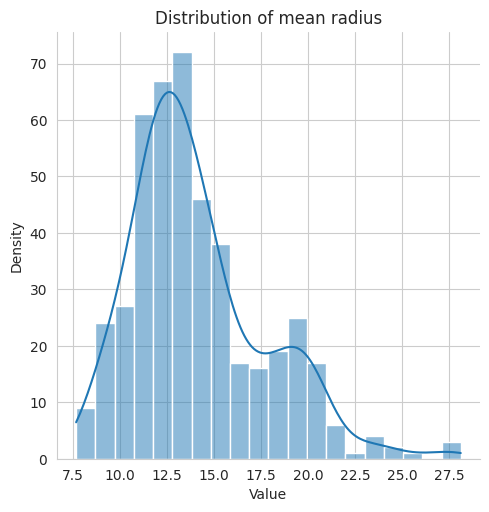

In [10]:
df = pd.DataFrame(X_train, columns=data.feature_names)
sns.set_style('whitegrid')
sns.displot(df["mean radius"], kde=True)
plt.title("Distribution of mean radius")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [11]:
# standardising the data
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

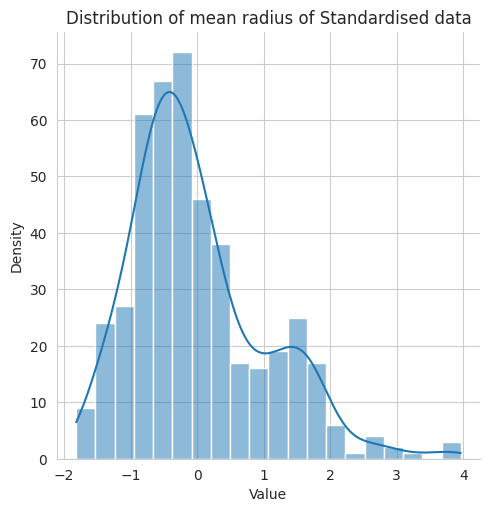

In [12]:
df = pd.DataFrame(X_train, columns=data.feature_names)
sns.set_style('whitegrid')
sns.displot(df["mean radius"], kde=True)
plt.title("Distribution of mean radius of Standardised data")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [13]:
type(X_train)
# pytorch supports tensors so we need to convert the dtype and move it to GPU

numpy.ndarray

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

**Neural network architecture**


In [15]:
# ANN - defining the neural network architecture

class NeuralNet(nn.Module):
  # inheriting the parameters and methods of "Module" to NeuralNet
    def __init__(self, input_size, hidden_size, output_size):
      #  input_size -- features,  hidden_size -- no of hidden layers, output_size -- no of neuron in output layer
      super(NeuralNet, self).__init__()

      self.fc1 = nn.Linear(input_size, hidden_size)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(hidden_size, output_size)
      self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      out = self.fc1(x)
      out = self.relu(out)
      out = self.fc2(out)
      out = self.sigmoid(out)
      return out


In [16]:
# define hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 100

In [17]:
# initialise the neural network and move it to GPU
model = NeuralNet(input_size,hidden_size,output_size).to(device)
model

NeuralNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
# define loss and optimiser
criterian = nn.BCELoss()
optimiser = optim.Adam(model.parameters(), lr = learning_rate)

**Training the neural network**

In [19]:
for epoch in range(num_epochs):
  # 100 iter
  model.train()
  optimiser.zero_grad()
  outputs = model(X_train)
  loss = criterian(outputs, y_train.view(-1,1))
  loss.backward()
  optimiser.step()

  # calculate accuracy
  with torch.no_grad():
    predicted = outputs.round()
    correct = (predicted == y_train.view(-1,1)).float().sum()
    accuracy = correct/y_train.size(0)

  if (epoch+1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss : {loss.item():.4f}, Accuracy : {accuracy.item() * 100:.2f} %")

Epoch [10/100], Loss : 0.5226, Accuracy : 90.11 %
Epoch [20/100], Loss : 0.4055, Accuracy : 91.87 %
Epoch [30/100], Loss : 0.3179, Accuracy : 92.97 %
Epoch [40/100], Loss : 0.2540, Accuracy : 93.85 %
Epoch [50/100], Loss : 0.2086, Accuracy : 94.07 %
Epoch [60/100], Loss : 0.1764, Accuracy : 95.60 %
Epoch [70/100], Loss : 0.1530, Accuracy : 96.26 %
Epoch [80/100], Loss : 0.1354, Accuracy : 96.92 %
Epoch [90/100], Loss : 0.1220, Accuracy : 96.92 %
Epoch [100/100], Loss : 0.1113, Accuracy : 97.36 %


**Model evaluation**

In [21]:
# eval on train set
model.eval()
with torch.no_grad():
  outputs = model(X_train)
  predicted = outputs.round()
  correct = (predicted == y_train.view(-1,1)).float().sum()
  accuracy = correct/y_train.size(0)
  print(f"Accuracy on training data: {accuracy.item() * 100:.2f} %")


Accuracy on training data: 97.36 %


In [23]:
# eval on train set
model.eval()
with torch.no_grad():
  outputs = model(X_test)
  predicted = outputs.round()
  correct = (predicted == y_test.view(-1,1)).float().sum()
  accuracy = correct/y_test.size(0)
  print(f"Accuracy on testing data: {accuracy.item() * 100:.2f} %")


Accuracy on testing data: 99.12 %
